<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/minyak_goreng_curah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7ff4e13e5bb0>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.minyak_goreng_curah.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


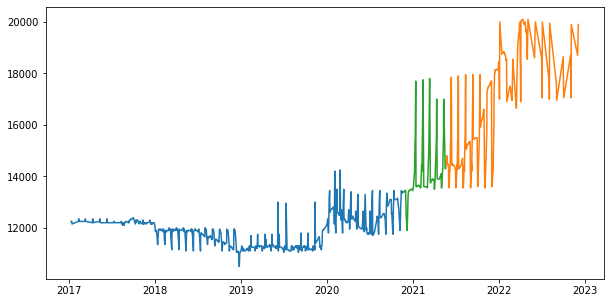

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_minyakgorengcurah_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 14s 252ms/step - loss: 0.2972 - mae: 0.5281 - mape: 97.6489 - val_loss: 0.1261 - val_mae: 0.3277 - val_mape: 81.3109
Epoch 2/30
44/44 [==============================] - 5s 121ms/step - loss: 0.2086 - mae: 0.4359 - mape: 79.3729 - val_loss: 0.0852 - val_mae: 0.2579 - val_mape: 62.2963
Epoch 3/30
44/44 [==============================] - 5s 109ms/step - loss: 0.1548 - mae: 0.3697 - mape: 66.3883 - val_loss: 0.0577 - val_mae: 0.1973 - val_mape: 45.8183
Epoch 4/30
44/44 [==============================] - 5s 122ms/step - loss: 0.1160 - mae: 0.3130 - mape: 55.2374 - val_loss: 0.0402 - val_mae: 0.1462 - val_mape: 31.9162
Epoch 5/30
44/44 [==============================] - 6s 147ms/step - loss: 0.0879 - mae: 0.2637 - mape: 45.4688 - val_loss: 0.0294 - val_mae: 0.1063 - val_mape: 21.3762
Epoch 6/30
44/44 [==============================] - 5s 116ms/step - loss: 0.0676 - mae: 0.2225 - mape: 37.4125 - val_loss: 0.0232 - val_mae: 0.0816 - val_mape:

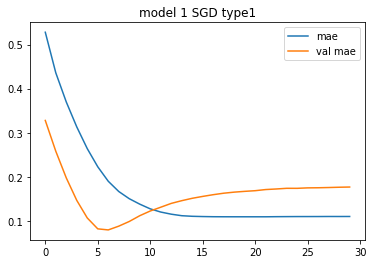

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 3s 15ms/step
1719.0098 9.9508915 2068.8587433655302


,date,actual,prediction
0,2021-05-20,14350,15400.481445
1,2021-05-21,14400,15403.331055
2,2021-05-24,14800,15408.132812
3,2021-05-25,14500,15412.943359
4,2021-05-27,14500,15417.875977
...,...,...,...
229,2022-11-02,17500,15837.034180
230,2022-11-03,17050,15837.671875
231,2022-11-04,19900,15836.814453
232,2022-12-01,18700,15837.224609


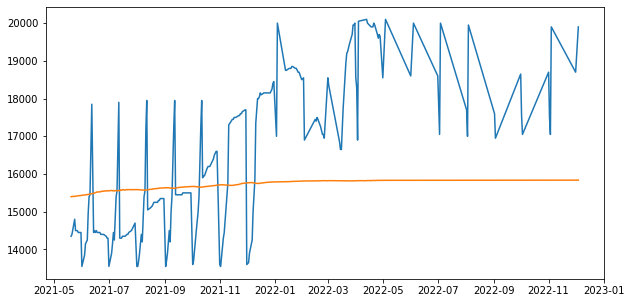

In [ ]:
prediction = forecast_predict(model, test_minyakgorengcurah_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_minyakgorengcurah = pd.DataFrame()
data_new_minyakgorengcurah['date'] = y_test
data_new_minyakgorengcurah['actual'] = x_test
data_new_minyakgorengcurah['prediction'] = data_result
data_new_minyakgorengcurah.to_csv('minyakgorengcurah_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_minyakgorengcurah.date, data_new_minyakgorengcurah.actual)
plt.plot(data_new_minyakgorengcurah.date, data_new_minyakgorengcurah.prediction)
data_new_minyakgorengcurah

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 19s 26ms/step - loss: 0.0261 - mae: 0.1349 - mape: 498895.3438 - val_loss: 0.0204 - val_mae: 0.1128 - val_mape: 28.4822
Epoch 2/30
718/718 [==============================] - 17s 24ms/step - loss: 0.0211 - mae: 0.1136 - mape: 517843.2188 - val_loss: 0.0207 - val_mae: 0.1154 - val_mape: 29.3220
Epoch 3/30
718/718 [==============================] - 17s 24ms/step - loss: 0.0205 - mae: 0.1119 - mape: 433729.9062 - val_loss: 0.0207 - val_mae: 0.1154 - val_mape: 29.3231
Epoch 4/30
718/718 [==============================] - 17s 24ms/step - loss: 0.0203 - mae: 0.1101 - mape: 436548.1875 - val_loss: 0.0207 - val_mae: 0.1153 - val_mape: 29.2961
Epoch 5/30
718/718 [==============================] - 17s 24ms/step - loss: 0.0195 - mae: 0.1074 - mape: 502265.0938 - val_loss: 0.0210 - val_mae: 0.1171 - val_mape: 29.8557
Epoch 6/30
718/718 [==============================] - 17s 23ms/step - loss: 0.0188 - mae: 0.1066 - mape: 472599.9688 - val_loss: 0

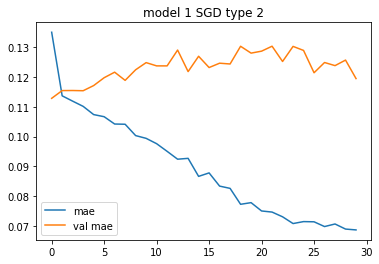

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1320.572 7.5528593 1691.945773362728


,date,actual,prediction
0,2021-05-20,14350,15400.481445
1,2021-05-21,14400,15403.331055
2,2021-05-24,14800,15408.132812
3,2021-05-25,14500,15412.943359
4,2021-05-27,14500,15417.875977
...,...,...,...
229,2022-11-02,17500,15837.034180
230,2022-11-03,17050,15837.671875
231,2022-11-04,19900,15836.814453
232,2022-12-01,18700,15837.224609


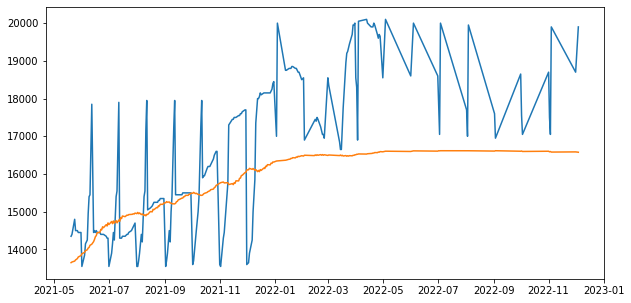

In [ ]:
win_size1 = 60
test_minyakgorengcurah_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_minyakgorengcurah_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_minyakgorengcurah_1 = pd.DataFrame()
data_new_minyakgorengcurah_1['actual'] = x_test
data_new_minyakgorengcurah_1['prediction'] = data_result_1
data_new_minyakgorengcurah_1.to_csv('minyakgorengcurah_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgorengcurah_1.actual)
plt.plot(y_test, data_new_minyakgorengcurah_1.prediction)
data_new_minyakgorengcurah

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 7s 87ms/step - loss: 0.0145 - mae: 0.0993 - mape: 30.5838 - val_loss: 0.0203 - val_mae: 0.1065 - val_mape: 26.1853
Epoch 2/30
84/84 [==============================] - 7s 84ms/step - loss: 0.0142 - mae: 0.0953 - mape: 28.1362 - val_loss: 0.0200 - val_mae: 0.1016 - val_mape: 24.5042
Epoch 3/30
84/84 [==============================] - 11s 127ms/step - loss: 0.0140 - mae: 0.0943 - mape: 27.5594 - val_loss: 0.0200 - val_mae: 0.1019 - val_mape: 24.6144
Epoch 4/30
84/84 [==============================] - 7s 79ms/step - loss: 0.0140 - mae: 0.0934 - mape: 26.9811 - val_loss: 0.0200 - val_mae: 0.1009 - val_mape: 24.2922
Epoch 5/30
84/84 [==============================] - 7s 86ms/step - loss: 0.0139 - mae: 0.0924 - mape: 26.3942 - val_loss: 0.0200 - val_mae: 0.1022 - val_mape: 24.7223
Epoch 6/30
84/84 [==============================] - 8s 89ms/step - loss: 0.0138 - mae: 0.0920 - mape: 26.2212 - val_loss: 0.0201 - val_mae: 0.1028 - val_mape: 24.9

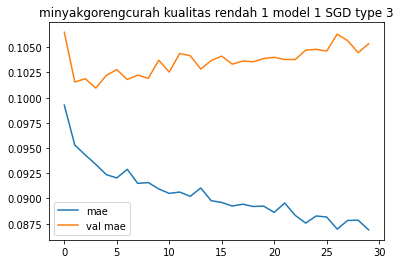

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('minyak gorengcurah kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 9ms/step
1279.0991 7.347353 1634.276521889732


,actual,prediction
0,14350,13188.819336
1,14400,13207.188477
2,14800,13236.445312
3,14500,13271.749023
4,14500,13313.293945
...,...,...
229,17500,16781.929688
230,17050,16790.855469
231,19900,16773.265625
232,18700,16778.132812


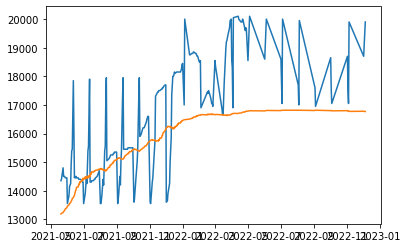

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_minyakgorengcurah_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_minyakgorengcurah_2 = pd.DataFrame()
# data_new_minyakgorengcurah1['date'] = date_test
data_new_minyakgorengcurah_2['actual'] = x_test
data_new_minyakgorengcurah_2['prediction'] = data_result_2
data_new_minyakgorengcurah_2.to_csv('minyakgorengcurah_model1_sgd_type3')

plt.plot(y_test, data_new_minyakgorengcurah_2.actual)
plt.plot(y_test, data_new_minyakgorengcurah_2.prediction)
data_new_minyakgorengcurah_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 11s 170ms/step - loss: 0.2821 - mae: 0.5137 - mape: 94.8683 - val_loss: 0.1230 - val_mae: 0.3228 - val_mape: 79.9514
Epoch 2/30
44/44 [==============================] - 6s 141ms/step - loss: 0.1731 - mae: 0.3922 - mape: 70.9475 - val_loss: 0.0561 - val_mae: 0.1926 - val_mape: 44.4695
Epoch 3/30
44/44 [==============================] - 6s 132ms/step - loss: 0.0578 - mae: 0.1994 - mape: 34.1117 - val_loss: 0.0200 - val_mae: 0.1074 - val_mape: 26.6291
Epoch 4/30
44/44 [==============================] - 6s 141ms/step - loss: 0.0197 - mae: 0.1147 - mape: 22.4074 - val_loss: 0.0270 - val_mae: 0.1473 - val_mape: 39.6732
Epoch 5/30
44/44 [==============================] - 6s 137ms/step - loss: 0.0192 - mae: 0.1154 - mape: 22.5184 - val_loss: 0.0284 - val_mae: 0.1523 - val_mape: 41.2978
Epoch 6/30
44/44 [==============================] - 6s 141ms/step - loss: 0.0192 - mae: 0.1161 - mape: 23.0286 - val_loss: 0.0282 - val_mae: 0.1518 - val_mape:

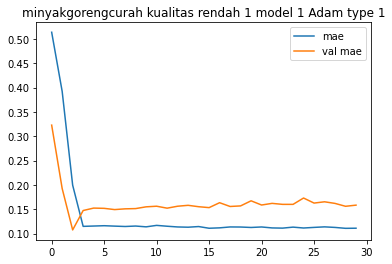

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('minyakgorengcurah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 3s 14ms/step
1302.475 7.609565 1612.06722874699


,actual,prediction
0,14350,14535.273438
1,14400,14547.212891
2,14800,14578.298828
3,14500,14596.442383
4,14500,14642.223633
...,...,...
229,17500,16824.906250
230,17050,16814.482422
231,19900,16786.453125
232,18700,16777.869141


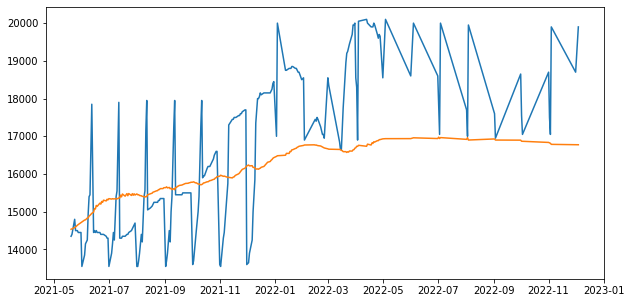

In [ ]:
prediction_a = forecast_predict(model_a, test_minyakgorengcurah_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_minyakgorengcurah_a = pd.DataFrame()
# data_new_minyakgorengcurah1['date'] = date_test
data_new_minyakgorengcurah_a['actual'] = x_test
data_new_minyakgorengcurah_a['prediction'] = data_result_a
data_new_minyakgorengcurah_a.to_csv('minyakgorengcurah_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_minyakgorengcurah_a.actual)
plt.plot(y_test, data_new_minyakgorengcurah_a.prediction)
data_new_minyakgorengcurah_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 20s 27ms/step - loss: 0.0099 - mae: 0.0715 - mape: 338109.8750 - val_loss: 0.0231 - val_mae: 0.1271 - val_mape: 32.8988
Epoch 2/30
718/718 [==============================] - 19s 27ms/step - loss: 0.0087 - mae: 0.0652 - mape: 317368.4375 - val_loss: 0.0329 - val_mae: 0.1662 - val_mape: 45.5958
Epoch 3/30
718/718 [==============================] - 20s 27ms/step - loss: 0.0093 - mae: 0.0672 - mape: 345053.4375 - val_loss: 0.0212 - val_mae: 0.1087 - val_mape: 26.7164
Epoch 4/30
718/718 [==============================] - 19s 27ms/step - loss: 0.0085 - mae: 0.0635 - mape: 329090.6562 - val_loss: 0.0227 - val_mae: 0.1212 - val_mape: 30.8706
Epoch 5/30
718/718 [==============================] - 19s 26ms/step - loss: 0.0089 - mae: 0.0659 - mape: 330412.0000 - val_loss: 0.0221 - val_mae: 0.1151 - val_mape: 28.7852
Epoch 6/30
718/718 [==============================] - 19s 27ms/step - loss: 0.0086 - mae: 0.0637 - mape: 343925.5312 - val_loss: 0

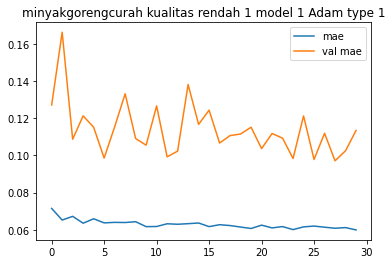

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('minyakgorengcurah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 9ms/step
1084.4288 6.4576244 1345.8796844443414


,actual,prediction
0,14350,13560.799805
1,14400,13589.503906
2,14800,13705.459961
3,14500,13750.209961
4,14500,13913.871094
...,...,...
229,17500,17337.382812
230,17050,17417.166016
231,19900,17250.433594
232,18700,17236.447266


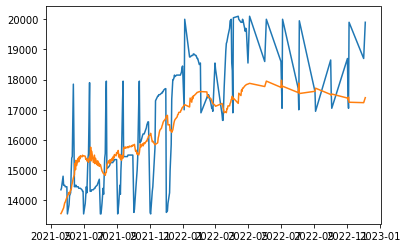

In [ ]:
prediction_a1 = forecast_predict(model_a, test_minyakgorengcurah_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_minyakgorengcurah_a1 = pd.DataFrame()
data_new_minyakgorengcurah_a1['actual'] = x_test
data_new_minyakgorengcurah_a1['prediction'] = data_result_a1
data_new_minyakgorengcurah_a1.to_csv('minyakgorengcurah_model1_adam_type2.csv')

plt.plot(y_test, data_new_minyakgorengcurah_a1.actual)
plt.plot(y_test, data_new_minyakgorengcurah_a1.prediction)
data_new_minyakgorengcurah_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 25s 292ms/step - loss: 0.0109 - mae: 0.0754 - mape: 20.3423 - val_loss: 0.0208 - val_mae: 0.0984 - val_mape: 22.7953
Epoch 2/30
84/84 [==============================] - 10s 112ms/step - loss: 0.0108 - mae: 0.0735 - mape: 19.3636 - val_loss: 0.0208 - val_mae: 0.0973 - val_mape: 22.3884
Epoch 3/30
84/84 [==============================] - 13s 148ms/step - loss: 0.0107 - mae: 0.0731 - mape: 19.2951 - val_loss: 0.0213 - val_mae: 0.0894 - val_mape: 19.3145
Epoch 4/30
84/84 [==============================] - 13s 147ms/step - loss: 0.0108 - mae: 0.0722 - mape: 18.4075 - val_loss: 0.0209 - val_mae: 0.1010 - val_mape: 23.7561
Epoch 5/30
84/84 [==============================] - 13s 157ms/step - loss: 0.0108 - mae: 0.0726 - mape: 18.8268 - val_loss: 0.0209 - val_mae: 0.1007 - val_mape: 23.6363
Epoch 6/30
84/84 [==============================] - 9s 103ms/step - loss: 0.0107 - mae: 0.0726 - mape: 18.9437 - val_loss: 0.0210 - val_mae: 0.1040 - val_m

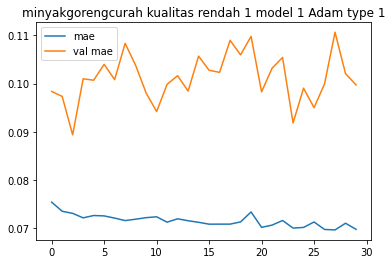

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('minyakgorengcurah kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 12ms/step
1150.0985 6.7557425 1440.0418830714611


,actual,prediction
0,14350,13185.412109
1,14400,13213.251953
2,14800,13350.259766
3,14500,13397.447266
4,14500,13587.625000
...,...,...
229,17500,17030.777344
230,17050,17200.287109
231,19900,16970.500000
232,18700,16965.150391


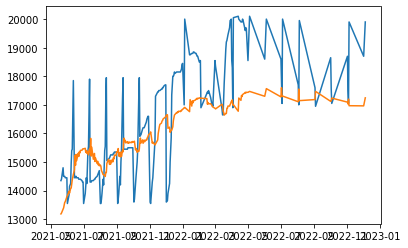

In [ ]:
prediction_a2 = forecast_predict(model_a, test_minyakgorengcurah_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_minyakgorengcurah_a2 = pd.DataFrame()
# data_new_minyakgorengcurah1['date'] = date_test
data_new_minyakgorengcurah_a2['actual'] = x_test
data_new_minyakgorengcurah_a2['prediction'] = data_result_a2
data_new_minyakgorengcurah_a2.to_csv('minyakgorengcurah_model1_adam_type3.csv')

plt.plot(y_test, data_new_minyakgorengcurah_a2.actual)
plt.plot(y_test, data_new_minyakgorengcurah_a2.prediction)
data_new_minyakgorengcurah_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 18s 329ms/step - loss: 0.1891 - mae: 0.4064 - mape: 74.3130 - val_loss: 0.0228 - val_mae: 0.0796 - val_mape: 15.2429
Epoch 2/15
44/44 [==============================] - 20s 460ms/step - loss: 0.0226 - mae: 0.1254 - mape: 24.5467 - val_loss: 0.0300 - val_mae: 0.1576 - val_mape: 42.9777
Epoch 3/15
44/44 [==============================] - 11s 256ms/step - loss: 0.0213 - mae: 0.1229 - mape: 24.2809 - val_loss: 0.0280 - val_mae: 0.1504 - val_mape: 40.6379
Epoch 4/15
44/44 [==============================] - 12s 268ms/step - loss: 0.0193 - mae: 0.1156 - mape: 22.6489 - val_loss: 0.0246 - val_mae: 0.1362 - val_mape: 36.0224
Epoch 5/15
44/44 [==============================] - 11s 257ms/step - loss: 0.0191 - mae: 0.1127 - mape: 22.1807 - val_loss: 0.0256 - val_mae: 0.1409 - val_mape: 37.5325
Epoch 6/15
44/44 [==============================] - 13s 270ms/step - loss: 0.0185 - mae: 0.1116 - mape: 21.6975 - val_loss: 0.0292 - val_mae: 0.1547 - val_

17/17 [==============================] - 0s 15ms/step - loss: 0.0387 - mae: 0.1734 - mape: 22.2693


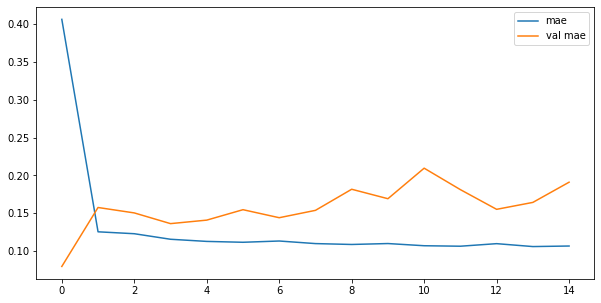

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_minyakgorengcurah_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_minyakgorengcurah1 = pd.DataFrame()
data_new_minyakgorengcurah1['actual'] = x_test
data_new_minyakgorengcurah1['prediction'] = data_result1
data_new_minyakgorengcurah1.to_csv('minyakgorengcurah_model2_adam_type1.csv')

data_new_minyakgorengcurah1

131/131 [==============================] - 7s 55ms/step
1284.2701 7.567157 1574.0562251711342


,actual,prediction
0,14350,12773.435547
1,14400,12789.658203
2,14800,12841.986328
3,14500,12903.669922
4,14500,12967.396484
...,...,...
229,17500,17065.560547
230,17050,17033.605469
231,19900,16885.283203
232,18700,16809.718750


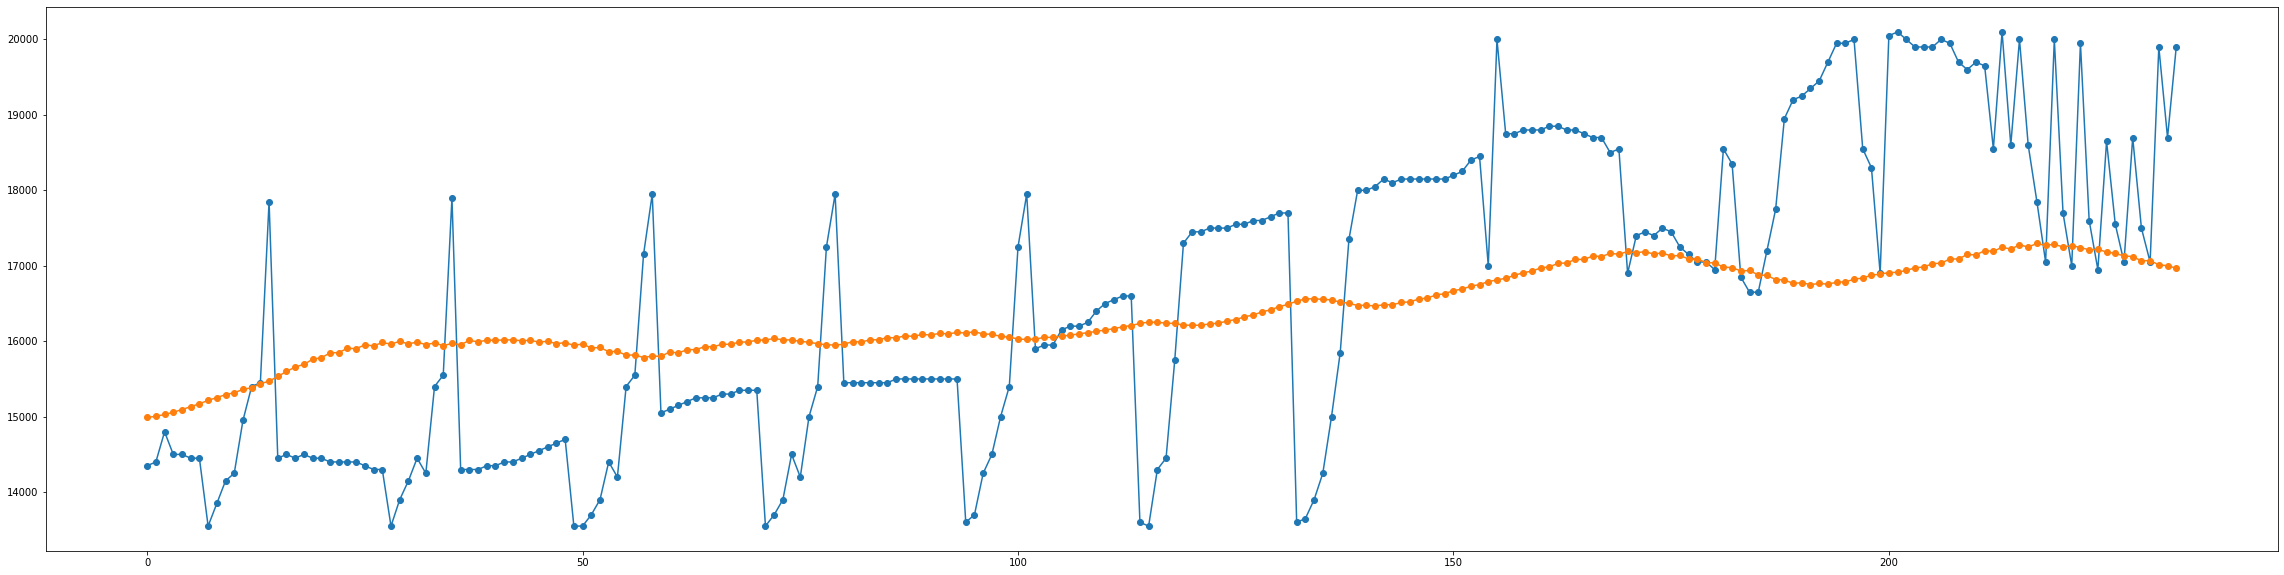

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_minyakgorengcurah1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_minyakgorengcurah1['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0083 - mae: 0.0610 - mape: 302497.3125 - val_loss: 0.0197 - val_mae: 0.0965 - val_mape: 22.4034
Epoch 2/15
718/718 [==============================] - 22s 31ms/step - loss: 0.0079 - mae: 0.0600 - mape: 332929.3438 - val_loss: 0.0199 - val_mae: 0.0885 - val_mape: 19.4183
Epoch 3/15
718/718 [==============================] - 21s 29ms/step - loss: 0.0079 - mae: 0.0586 - mape: 350918.5312 - val_loss: 0.0225 - val_mae: 0.1236 - val_mape: 32.0925
Epoch 4/15
718/718 [==============================] - 22s 30ms/step - loss: 0.0076 - mae: 0.0575 - mape: 267345.6250 - val_loss: 0.0195 - val_mae: 0.0896 - val_mape: 19.8886
Epoch 5/15
718/718 [==============================] - 23s 31ms/step - loss: 0.0077 - mae: 0.0578 - mape: 270324.8438 - val_loss: 0.0212 - val_mae: 0.1160 - val_mape: 29.3352
Epoch 6/15
718/718 [==============================] - 27s 37ms/step - loss: 0.0079 - mae: 0.0583 - mape: 281164.4688 - val_loss: 0

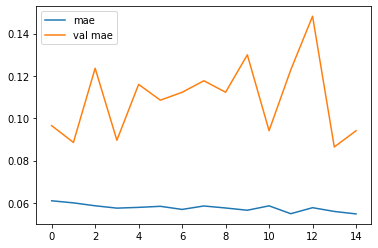

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
1298.6191 7.625862 1574.0562251711342


,actual,prediction
0,14350,14069.036133
1,14400,14138.765625
2,14800,14020.374023
3,14500,14159.757812
4,14500,14029.808594
...,...,...
229,17500,17340.806641
230,17050,17310.386719
231,19900,17254.515625
232,18700,17126.269531


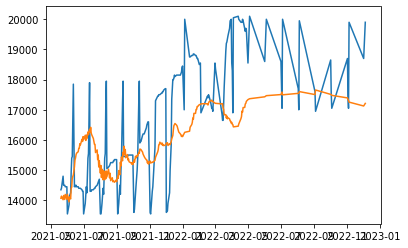

In [ ]:
prediction1_1 = forecast_predict(model1, test_minyakgorengcurah_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_minyakgorengcurah1_1 = pd.DataFrame()
data_new_minyakgorengcurah1_1['actual'] = x_test
data_new_minyakgorengcurah1_1['prediction'] = data_result1_1
data_new_minyakgorengcurah1_1.to_csv('minyakgorengcurah_model2_adam_type2.csv')

plt.plot(y_test, data_new_minyakgorengcurah1_1.actual)
plt.plot(y_test, data_new_minyakgorengcurah1_1.prediction)
data_new_minyakgorengcurah1_1

#### Type 3

In [12]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 37s 316ms/step - loss: 0.0596 - mae: 0.1812 - mape: 47.1466 - val_loss: 0.0204 - val_mae: 0.1079 - val_mape: 26.7344
Epoch 2/15
84/84 [==============================] - 18s 214ms/step - loss: 0.0144 - mae: 0.0944 - mape: 27.0161 - val_loss: 0.0208 - val_mae: 0.1105 - val_mape: 27.6010
Epoch 3/15
84/84 [==============================] - 18s 212ms/step - loss: 0.0136 - mae: 0.0910 - mape: 25.6257 - val_loss: 0.0210 - val_mae: 0.1107 - val_mape: 27.6138
Epoch 4/15
84/84 [==============================] - 18s 210ms/step - loss: 0.0134 - mae: 0.0879 - mape: 23.7719 - val_loss: 0.0203 - val_mae: 0.1017 - val_mape: 24.5071
Epoch 5/15
84/84 [==============================] - 18s 209ms/step - loss: 0.0132 - mae: 0.0858 - mape: 22.8874 - val_loss: 0.0216 - val_mae: 0.1137 - val_mape: 28.5646
Epoch 6/15
84/84 [==============================] - 20s 234ms/step - loss: 0.0129 - mae: 0.0851 - mape: 23.0098 - val_loss: 0.0204 - val_mae: 0.0941 - val_

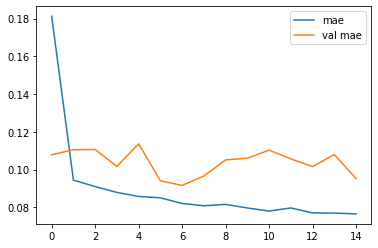

In [13]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 4s 16ms/step
1146.0767 6.71665 1426.105097810116


,actual,prediction
0,14350,13082.987305
1,14400,13117.642578
2,14800,13171.010742
3,14500,13219.188477
4,14500,13314.017578
...,...,...
229,17500,17568.751953
230,17050,17444.238281
231,19900,17388.068359
232,18700,17276.156250


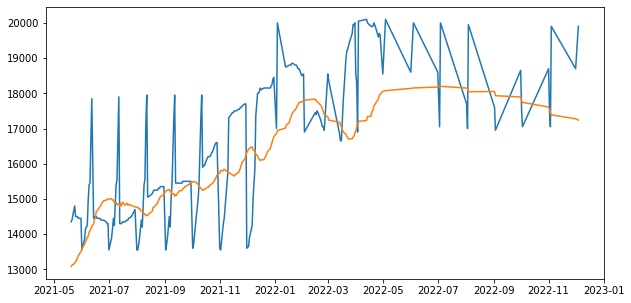

In [14]:
prediction1_2 = forecast_predict(model1, test_minyakgorengcurah_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_minyakgorengcurah1_2 = pd.DataFrame()
data_new_minyakgorengcurah1_2['actual'] = x_test
data_new_minyakgorengcurah1_2['prediction'] = data_result1_2
data_new_minyakgorengcurah1_2.to_csv('minyakgorengcurah_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgorengcurah1_2.actual)
plt.plot(y_test, data_new_minyakgorengcurah1_2.prediction)

data_new_minyakgorengcurah1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 16s 282ms/step - loss: 0.3030 - mae: 0.5328 - mape: 98.5671 - val_loss: 0.1213 - val_mae: 0.3203 - val_mape: 79.2847
Epoch 2/15
44/44 [==============================] - 12s 275ms/step - loss: 0.1911 - mae: 0.4160 - mape: 75.6256 - val_loss: 0.0711 - val_mae: 0.2288 - val_mape: 54.3694
Epoch 3/15
44/44 [==============================] - 16s 360ms/step - loss: 0.1265 - mae: 0.3295 - mape: 58.5243 - val_loss: 0.0434 - val_mae: 0.1569 - val_mape: 34.8267
Epoch 4/15
44/44 [==============================] - 26s 580ms/step - loss: 0.0872 - mae: 0.2631 - mape: 45.4478 - val_loss: 0.0285 - val_mae: 0.1029 - val_mape: 20.5611
Epoch 5/15
44/44 [==============================] - 11s 256ms/step - loss: 0.0617 - mae: 0.2098 - mape: 34.9789 - val_loss: 0.0214 - val_mae: 0.0779 - val_mape: 15.2136
Epoch 6/15
44/44 [==============================] - 11s 258ms/step - loss: 0.0450 - mae: 0.1725 - mape: 28.3197 - val_loss: 0.0191 - val_mae: 0.0861 - val_

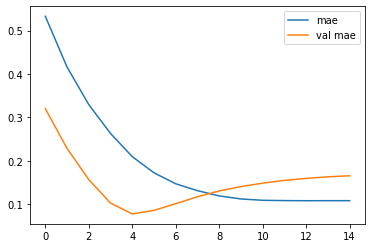

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 24ms/step
1706.6296 9.816264 2086.041346665976


,actual,prediction
0,14350,15189.200195
1,14400,15193.217773
2,14800,15198.568359
3,14500,15205.522461
4,14500,15213.402344
...,...,...
229,17500,15776.900391
230,17050,15773.739258
231,19900,15775.500000
232,18700,15773.452148


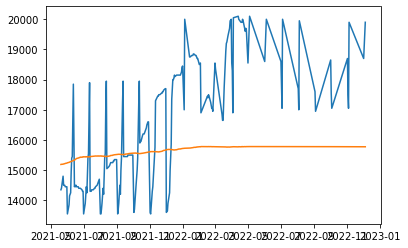

In [ ]:
prediction1_a = forecast_predict(model1_a, test_minyakgorengcurah_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_minyakgorengcurah1_a = pd.DataFrame()
data_new_minyakgorengcurah1_a['actual'] = x_test
data_new_minyakgorengcurah1_a['prediction'] = data_result1_a
data_new_minyakgorengcurah1_a.to_csv('minyakgorengcurah_model2_sgd_type1.csv')


plt.plot(y_test, data_new_minyakgorengcurah1_a.actual)
plt.plot(y_test, data_new_minyakgorengcurah1_a.prediction)

data_new_minyakgorengcurah1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 21s 29ms/step - loss: 0.0225 - mae: 0.1215 - mape: 492465.7500 - val_loss: 0.0214 - val_mae: 0.1201 - val_mape: 30.8416
Epoch 2/15
718/718 [==============================] - 22s 30ms/step - loss: 0.0190 - mae: 0.1060 - mape: 417204.6250 - val_loss: 0.0215 - val_mae: 0.1205 - val_mape: 30.9714
Epoch 3/15
718/718 [==============================] - 22s 31ms/step - loss: 0.0177 - mae: 0.1024 - mape: 461761.6562 - val_loss: 0.0220 - val_mae: 0.1232 - val_mape: 31.8268
Epoch 4/15
718/718 [==============================] - 22s 30ms/step - loss: 0.0172 - mae: 0.1021 - mape: 394944.6562 - val_loss: 0.0219 - val_mae: 0.1228 - val_mape: 31.6870
Epoch 5/15
718/718 [==============================] - 22s 31ms/step - loss: 0.0163 - mae: 0.0975 - mape: 386142.9688 - val_loss: 0.0222 - val_mae: 0.1240 - val_mape: 32.0668
Epoch 6/15
718/718 [==============================] - 22s 30ms/step - loss: 0.0156 - mae: 0.0952 - mape: 425718.4062 - val_loss: 0

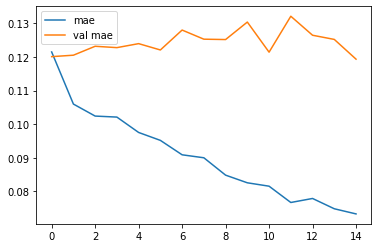

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
1358.8329 7.7608438 1727.9447329124853


,actual,prediction
0,14350,13722.121094
1,14400,13736.632812
2,14800,13756.499023
3,14500,13781.410156
4,14500,13810.059570
...,...,...
229,17500,16585.640625
230,17050,16565.910156
231,19900,16567.427734
232,18700,16548.671875


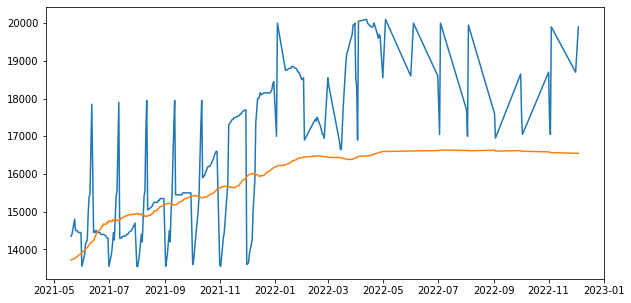

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_minyakgorengcurah_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_minyakgorengcurah1_a1 = pd.DataFrame()
data_new_minyakgorengcurah1_a1['actual'] = x_test
data_new_minyakgorengcurah1_a1['prediction'] = data_result1_a1
data_new_minyakgorengcurah1_a1.to_csv('minyakgorengcurah_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgorengcurah1_a1.actual)
plt.plot(y_test, data_new_minyakgorengcurah1_a1.prediction)
data_new_minyakgorengcurah1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 14s 163ms/step - loss: 0.0154 - mae: 0.1047 - mape: 33.7768 - val_loss: 0.0205 - val_mae: 0.1064 - val_mape: 26.2027
Epoch 2/15
84/84 [==============================] - 14s 163ms/step - loss: 0.0149 - mae: 0.0992 - mape: 30.4004 - val_loss: 0.0202 - val_mae: 0.1020 - val_mape: 24.6929
Epoch 3/15
84/84 [==============================] - 14s 160ms/step - loss: 0.0148 - mae: 0.0970 - mape: 28.8963 - val_loss: 0.0202 - val_mae: 0.1023 - val_mape: 24.7925
Epoch 4/15
84/84 [==============================] - 14s 163ms/step - loss: 0.0146 - mae: 0.0958 - mape: 28.2369 - val_loss: 0.0202 - val_mae: 0.1019 - val_mape: 24.6252
Epoch 5/15
84/84 [==============================] - 14s 167ms/step - loss: 0.0145 - mae: 0.0957 - mape: 28.2764 - val_loss: 0.0203 - val_mae: 0.1031 - val_mape: 25.0403
Epoch 6/15
84/84 [==============================] - 14s 164ms/step - loss: 0.0143 - mae: 0.0957 - mape: 28.3954 - val_loss: 0.0204 - val_mae: 0.1037 - val_

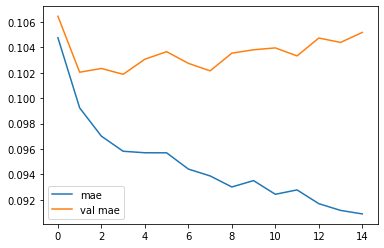

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 13ms/step
1326.8842 7.6003036 1682.2261292703784


,actual,prediction
0,14350,13298.989258
1,14400,13317.372070
2,14800,13341.382812
3,14500,13372.539062
4,14500,13408.278320
...,...,...
229,17500,16740.757812
230,17050,16718.232422
231,19900,16720.126953
232,18700,16699.175781


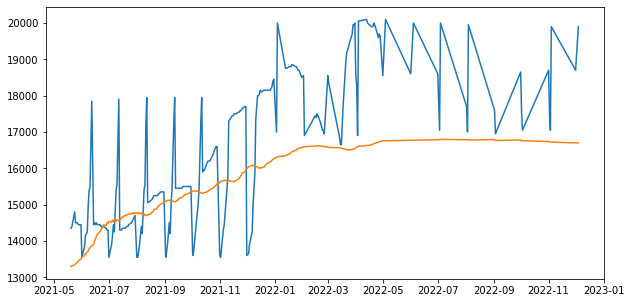

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_minyakgorengcurah_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_minyakgorengcurah1_a2 = pd.DataFrame()
data_new_minyakgorengcurah1_a2['actual'] = x_test
data_new_minyakgorengcurah1_a2['prediction'] = data_result1_a2
data_new_minyakgorengcurah1_a2.to_csv('minyakgorengcurah_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgorengcurah1_a2.actual)
plt.plot(y_test, data_new_minyakgorengcurah1_a2.prediction)

data_new_minyakgorengcurah1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 9s 109ms/step - loss: 0.2701 - mae: 0.5021 - mape: 92.5333 - val_loss: 0.1185 - val_mae: 0.3158 - val_mape: 78.0595
Epoch 2/50
44/44 [==============================] - 4s 81ms/step - loss: 0.1961 - mae: 0.4213 - mape: 76.4729 - val_loss: 0.0766 - val_mae: 0.2405 - val_mape: 57.5814
Epoch 3/50
44/44 [==============================] - 4s 81ms/step - loss: 0.1421 - mae: 0.3520 - mape: 62.8902 - val_loss: 0.0500 - val_mae: 0.1768 - val_mape: 40.2565
Epoch 4/50
44/44 [==============================] - 3s 77ms/step - loss: 0.1039 - mae: 0.2926 - mape: 51.1874 - val_loss: 0.0336 - val_mae: 0.1222 - val_mape: 25.4174
Epoch 5/50
44/44 [==============================] - 4s 95ms/step - loss: 0.0768 - mae: 0.2418 - mape: 41.1640 - val_loss: 0.0244 - val_mae: 0.0875 - val_mape: 16.9818
Epoch 6/50
44/44 [==============================] - 4s 84ms/step - loss: 0.0578 - mae: 0.2003 - mape: 33.1413 - val_loss: 0.0201 - val_mae: 0.0786 - val_mape: 16.04

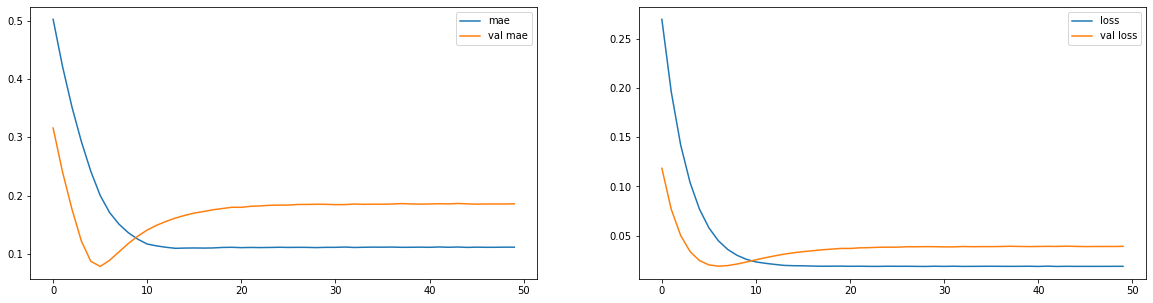

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 2s 12ms/step
1750.1897 10.157398 2088.315110322195


,actual,prediction
0,14350,15548.382812
1,14400,15550.515625
2,14800,15548.964844
3,14500,15549.068359
4,14500,15554.933594
...,...,...
229,17500,15823.094727
230,17050,15825.263672
231,19900,15826.876953
232,18700,15823.269531


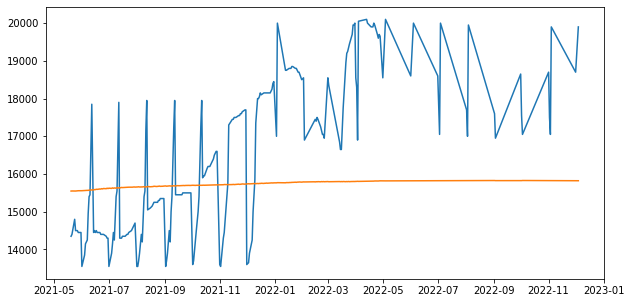

In [ ]:
prediction2 = forecast_predict(model2, test_minyakgorengcurah_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_minyakgorengcurah2 = pd.DataFrame()
data_new_minyakgorengcurah2['actual'] = x_test
data_new_minyakgorengcurah2['prediction'] = data_result2
data_new_minyakgorengcurah2.to_csv('minyakgorengcurah_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgorengcurah2.actual)
plt.plot(y_test, data_new_minyakgorengcurah2.prediction)
data_new_minyakgorengcurah2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 12s 17ms/step - loss: 0.0286 - mae: 0.1430 - mape: 569087.8750 - val_loss: 0.0204 - val_mae: 0.1135 - val_mape: 28.7329
Epoch 2/50
718/718 [==============================] - 11s 15ms/step - loss: 0.0233 - mae: 0.1197 - mape: 509886.3125 - val_loss: 0.0206 - val_mae: 0.1153 - val_mape: 29.3119
Epoch 3/50
718/718 [==============================] - 11s 15ms/step - loss: 0.0229 - mae: 0.1184 - mape: 490120.8125 - val_loss: 0.0205 - val_mae: 0.1143 - val_mape: 28.9957
Epoch 4/50
718/718 [==============================] - 10s 14ms/step - loss: 0.0226 - mae: 0.1174 - mape: 496728.3438 - val_loss: 0.0208 - val_mae: 0.1163 - val_mape: 29.6283
Epoch 5/50
718/718 [==============================] - 11s 16ms/step - loss: 0.0219 - mae: 0.1139 - mape: 490835.9375 - val_loss: 0.0213 - val_mae: 0.1197 - val_mape: 30.7579
Epoch 6/50
718/718 [==============================] - 13s 17ms/step - loss: 0.0221 - mae: 0.1161 - mape: 374205.7188 - val_loss: 0

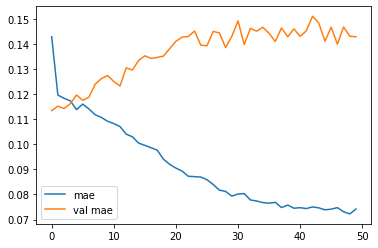

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_minyakgorengcurah_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_minyakgorengcurah2_1 = pd.DataFrame()
data_new_minyakgorengcurah2_1['actual'] = x_test
data_new_minyakgorengcurah2_1['prediction'] = data_result2_1
data_new_minyakgorengcurah2_1.to_csv('minyakgorengcurah_model3_sgd_type2.csv')

data_new_minyakgorengcurah2

199/199 [==============================] - 1s 3ms/step
1326.4469 7.5727887 1692.8684975508286


,actual,prediction
0,14350,15548.382812
1,14400,15550.515625
2,14800,15548.964844
3,14500,15549.068359
4,14500,15554.933594
...,...,...
229,17500,15823.094727
230,17050,15825.263672
231,19900,15826.876953
232,18700,15823.269531


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 5s 55ms/step - loss: 0.0163 - mae: 0.1047 - mape: 31.5563 - val_loss: 0.0240 - val_mae: 0.1321 - val_mape: 34.6562
Epoch 2/50
84/84 [==============================] - 5s 62ms/step - loss: 0.0157 - mae: 0.0991 - mape: 28.5680 - val_loss: 0.0233 - val_mae: 0.1287 - val_mape: 33.5147
Epoch 3/50
84/84 [==============================] - 5s 56ms/step - loss: 0.0156 - mae: 0.0986 - mape: 28.0472 - val_loss: 0.0234 - val_mae: 0.1288 - val_mape: 33.5518
Epoch 4/50
84/84 [==============================] - 5s 53ms/step - loss: 0.0155 - mae: 0.0978 - mape: 27.7103 - val_loss: 0.0234 - val_mae: 0.1287 - val_mape: 33.5185
Epoch 5/50
84/84 [==============================] - 4s 51ms/step - loss: 0.0157 - mae: 0.0986 - mape: 27.8850 - val_loss: 0.0231 - val_mae: 0.1272 - val_mape: 33.0261
Epoch 6/50
84/84 [==============================] - 5s 54ms/step - loss: 0.0157 - mae: 0.0986 - mape: 27.7663 - val_loss: 0.0235 - val_mae: 0.1297 - val_mape: 33.848

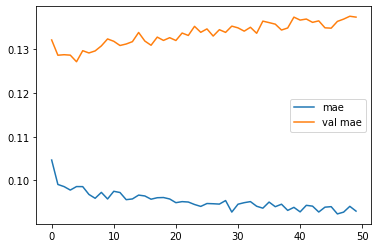

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_minyakgorengcurah_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_minyakgorengcurah2_2 = pd.DataFrame()
data_new_minyakgorengcurah2_2['actual'] = x_test
data_new_minyakgorengcurah2_2['prediction'] = data_result2_2
data_new_minyakgorengcurah2_2.to_csv('minyakgorengcurah_model3_sgd-type3.csv')

data_new_minyakgorengcurah2_2

181/181 [==============================] - 1s 7ms/step
1251.1757 7.192152 1604.4108731867907


,actual,prediction
0,14350,13193.967773
1,14400,13202.411133
2,14800,13250.521484
3,14500,13267.960938
4,14500,13305.490234
...,...,...
229,17500,16996.867188
230,17050,16970.083984
231,19900,16958.361328
232,18700,16958.917969


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 9s 116ms/step - loss: 0.2282 - mae: 0.4579 - mape: 84.1053 - val_loss: 0.0774 - val_mae: 0.2417 - val_mape: 57.8619
Epoch 2/50
44/44 [==============================] - 4s 98ms/step - loss: 0.0612 - mae: 0.2010 - mape: 37.1435 - val_loss: 0.0193 - val_mae: 0.0943 - val_mape: 22.0175
Epoch 3/50
44/44 [==============================] - 4s 92ms/step - loss: 0.0241 - mae: 0.1249 - mape: 24.1120 - val_loss: 0.0202 - val_mae: 0.1082 - val_mape: 26.7476
Epoch 4/50
44/44 [==============================] - 4s 97ms/step - loss: 0.0245 - mae: 0.1302 - mape: 25.8906 - val_loss: 0.0194 - val_mae: 0.0968 - val_mape: 22.9357
Epoch 5/50
44/44 [==============================] - 4s 95ms/step - loss: 0.0235 - mae: 0.1259 - mape: 24.7637 - val_loss: 0.0207 - val_mae: 0.1133 - val_mape: 28.4567
Epoch 6/50
44/44 [==============================] - 4s 91ms/step - loss: 0.0226 - mae: 0.1236 - mape: 24.0038 - val_loss: 0.0212 - val_mae: 0.1177 - val_mape: 29.90

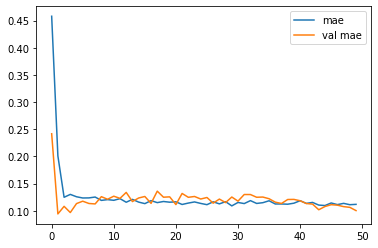

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_minyakgorengcurah_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_minyakgorengcurah2_a = pd.DataFrame()
data_new_minyakgorengcurah2_a['actual'] = x_test
data_new_minyakgorengcurah2_a['prediction'] = data_result2_a
data_new_minyakgorengcurah2_a.to_csv('minyakgorengcurah_model3_adam-type1.csv')

data_new_minyakgorengcurah2_a

131/131 [==============================] - 2s 10ms/step
1560.2288 9.110381 1863.8022963823175


,actual,prediction
0,14350,15256.374023
1,14400,15273.566406
2,14800,15288.024414
3,14500,15294.847656
4,14500,15308.993164
...,...,...
229,17500,16252.592773
230,17050,16247.578125
231,19900,16251.315430
232,18700,16226.958008


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 11s 16ms/step - loss: 0.0117 - mae: 0.0791 - mape: 413513.5312 - val_loss: 0.0208 - val_mae: 0.1100 - val_mape: 27.3581
Epoch 2/50
718/718 [==============================] - 12s 16ms/step - loss: 0.0101 - mae: 0.0716 - mape: 348837.3125 - val_loss: 0.0222 - val_mae: 0.1199 - val_mape: 30.5552
Epoch 3/50
718/718 [==============================] - 11s 16ms/step - loss: 0.0101 - mae: 0.0725 - mape: 417971.0312 - val_loss: 0.0250 - val_mae: 0.1342 - val_mape: 35.1311
Epoch 4/50
718/718 [==============================] - 11s 15ms/step - loss: 0.0098 - mae: 0.0698 - mape: 333131.1562 - val_loss: 0.0247 - val_mae: 0.1339 - val_mape: 35.0529
Epoch 5/50
718/718 [==============================] - 12s 17ms/step - loss: 0.0099 - mae: 0.0699 - mape: 315331.5312 - val_loss: 0.0245 - val_mae: 0.1315 - val_mape: 34.2390
Epoch 6/50
718/718 [==============================] - 12s 16ms/step - loss: 0.0097 - mae: 0.0695 - mape: 355605.5625 - val_loss: 0

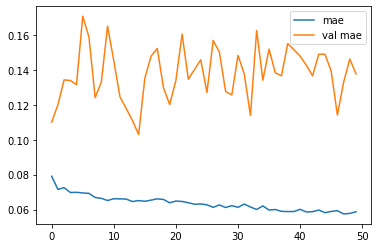

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1483.9216 8.663447 1795.128686194948


,actual,prediction
0,14350,14183.041016
1,14400,14396.461914
2,14800,14557.329102
3,14500,14523.332031
4,14500,14570.115234
...,...,...
229,17500,16287.081055
230,17050,16274.403320
231,19900,16242.559570
232,18700,16210.567383


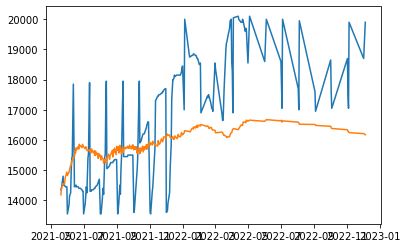

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_minyakgorengcurah_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_minyakgorengcurah2_a1 = pd.DataFrame()
data_new_minyakgorengcurah2_a1['actual'] = x_test
data_new_minyakgorengcurah2_a1['prediction'] = data_result2_a1
data_new_minyakgorengcurah2_a1.to_csv('minyakgorengcurah_model3_adam-type2.csv')

plt.plot(y_test, data_new_minyakgorengcurah2_a1.actual)
plt.plot(y_test, data_new_minyakgorengcurah2_a1.prediction)
data_new_minyakgorengcurah2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 5s 60ms/step - loss: 0.0105 - mae: 0.0695 - mape: 17.9105 - val_loss: 0.0228 - val_mae: 0.1178 - val_mape: 29.9765
Epoch 2/50
84/84 [==============================] - 5s 60ms/step - loss: 0.0099 - mae: 0.0650 - mape: 16.5356 - val_loss: 0.0231 - val_mae: 0.1213 - val_mape: 31.1447
Epoch 3/50
84/84 [==============================] - 5s 58ms/step - loss: 0.0099 - mae: 0.0650 - mape: 16.3439 - val_loss: 0.0246 - val_mae: 0.1307 - val_mape: 34.1761
Epoch 4/50
84/84 [==============================] - 6s 66ms/step - loss: 0.0098 - mae: 0.0642 - mape: 16.3500 - val_loss: 0.0252 - val_mae: 0.1342 - val_mape: 35.3375
Epoch 5/50
84/84 [==============================] - 6s 66ms/step - loss: 0.0096 - mae: 0.0656 - mape: 16.7520 - val_loss: 0.0238 - val_mae: 0.1265 - val_mape: 32.8137
Epoch 6/50
84/84 [==============================] - 6s 64ms/step - loss: 0.0096 - mae: 0.0637 - mape: 16.0792 - val_loss: 0.0242 - val_mae: 0.1286 - val_mape: 33.498

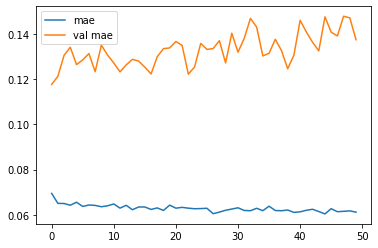

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
1210.0569 7.268736 1458.6417483398725


,actual,prediction
0,14350,14423.802734
1,14400,13688.181641
2,14800,14071.960938
3,14500,14121.036133
4,14500,14652.812500
...,...,...
229,17500,17476.369141
230,17050,17523.265625
231,19900,17470.906250
232,18700,17549.460938


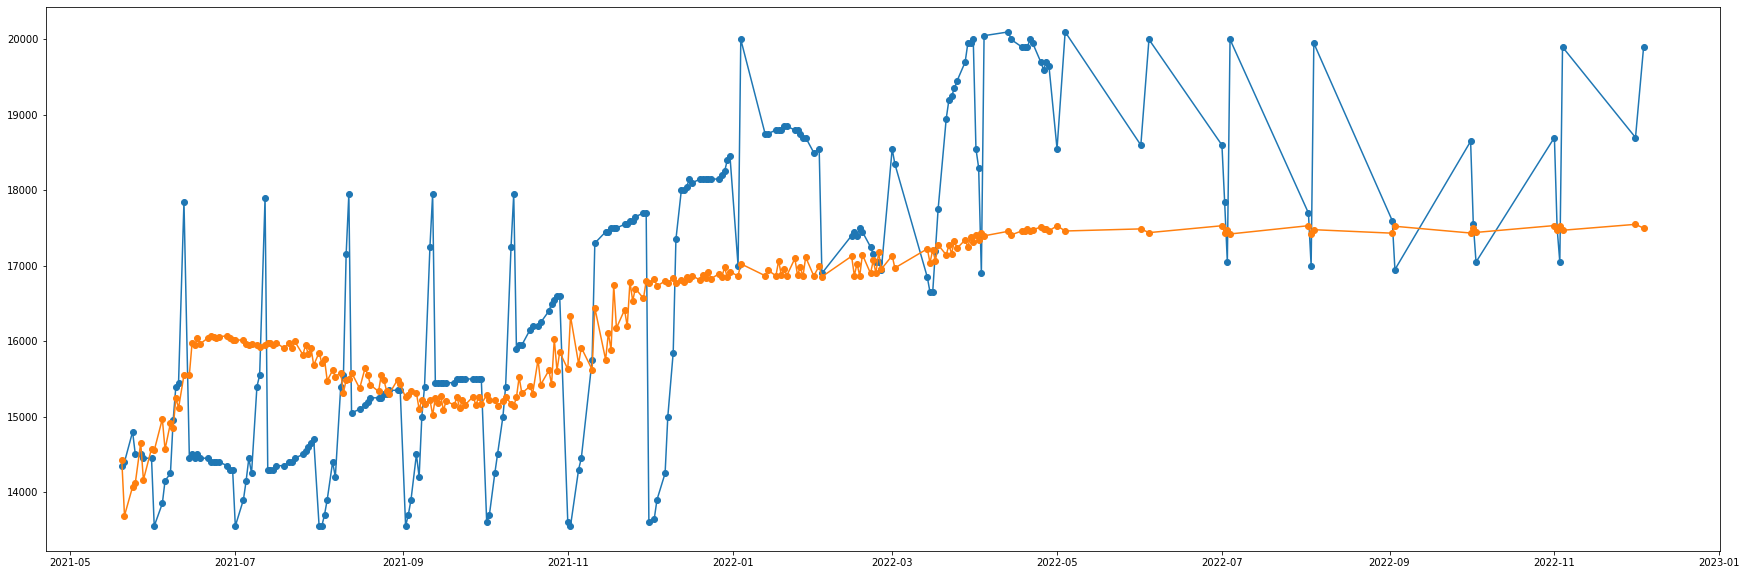

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_minyakgorengcurah_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_minyakgorengcurah2_a2 = pd.DataFrame()
data_new_minyakgorengcurah2_a2['actual'] = x_test
data_new_minyakgorengcurah2_a2['prediction'] = data_result2_a2
data_new_minyakgorengcurah2_a2.to_csv('minyakgorengcurah_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_minyakgorengcurah2_a2.actual, '-o')
plt.plot(y_test,data_new_minyakgorengcurah2_a2.prediction, '-o')
data_new_minyakgorengcurah2_a2